In [1]:
import pandas as pd
import re
from nltk.corpus import stopwords
import nltk
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from sklearn.decomposition import  KernelPCA
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import  CountVectorizer


2023-05-01 16:03:02.345886: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-01 16:03:03.020969: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
RANDOM_SEED = 42
NUMBER_OF_CATEGORIZED_WORDS_LARGE=10000
NUMBER_OF_CATEGORIZED_WORDS_SMALL=1500

In [3]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

2023-05-01 16:03:03.898490: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-01 16:03:03.978601: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-01 16:03:03.978816: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

# Wstępne przetwarzenie danych

## Wczytywanie danych

In [4]:
df = pd.read_csv("data/file.csv", index_col=0)

In [5]:
df.head()

,tweets,labels
0,ChatGPT: Optimizing Language Models for Dialog...,neutral
1,"Try talking with ChatGPT, our new AI system wh...",good
2,ChatGPT: Optimizing Language Models for Dialog...,neutral
3,"THRILLED to share that ChatGPT, our new model ...",good
4,"As of 2 minutes ago, @OpenAI released their ne...",bad


In [6]:
print(f"Ilość danych: {df.shape[0]}")

Ilość danych: 219294


Tweety Good 56011
Tweety Neutral 55487
Tweety Bad 107796


<BarContainer object of 3 artists>

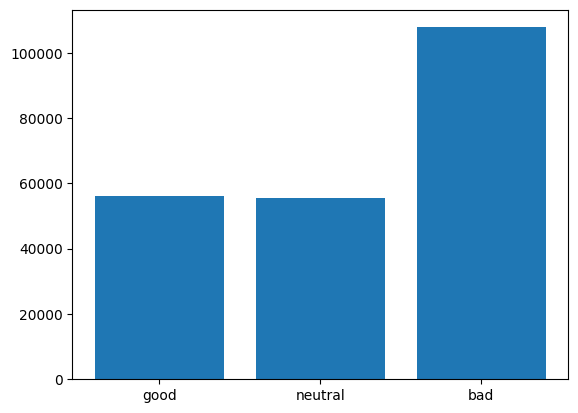

In [7]:
good_count = np.sum(df["labels"]=="good") 
neutral_count = np.sum(df["labels"]=="neutral") 
bad_count = np.sum(df["labels"]=="bad") 

print(f"Tweety Good {good_count}")
print(f"Tweety Neutral {neutral_count}")
print(f"Tweety Bad {bad_count}")

min_count = min([good_count,neutral_count,bad_count])
plt.bar(["good", "neutral", "bad"], [good_count,neutral_count,bad_count] )

In [8]:
print(f"Przykład tweetu dla kategorii good: {df.loc[df.labels=='good'].iloc[0].tweets}")
print(f"Przykład tweetu dla kategorii neutral: {df.loc[df.labels=='neutral'].iloc[0].tweets}")
print(f"Przykład tweetu dla kategorii bad: {df.loc[df.labels=='bad'].iloc[0].tweets}")

Przykład tweetu dla kategorii good: Try talking with ChatGPT, our new AI system which is optimized for dialogue. Your feedback will help us improve it. https://t.co/sHDm57g3Kr
Przykład tweetu dla kategorii neutral: ChatGPT: Optimizing Language Models for Dialogue https://t.co/K9rKRygYyn @OpenAI
Przykład tweetu dla kategorii bad: As of 2 minutes ago, @OpenAI released their new ChatGPT. \n\nAnd you can use it right now 👇 https://t.co/VyPGPNw988 https://t.co/cSn5h6h1M1


## Przetwarzanie zbioru

### Ujednolicenie liczby tweetów dla każdej kategorii

In [9]:
good_rows = df.loc[df.labels=="good"].iloc[:min_count]
neutral_rows = df.loc[df.labels=="neutral"].iloc[:min_count]
bad_rows = df.loc[df.labels=="bad"].iloc[:min_count]

In [10]:
df = pd.concat([good_rows, neutral_rows, bad_rows])

Tweety Good 55487
Tweety Neutral 55487
Tweety Bad 55487


<BarContainer object of 3 artists>

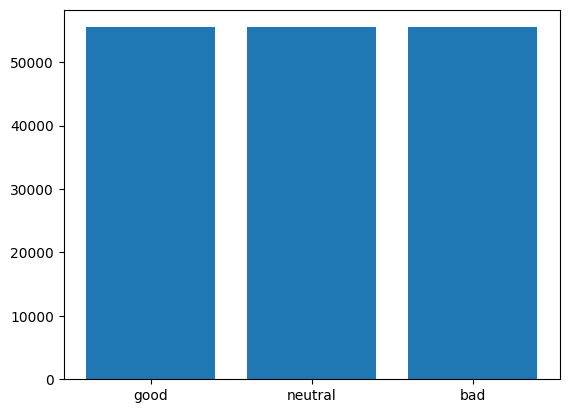

In [11]:
good_count = np.sum(df["labels"]=="good") 
neutral_count = np.sum(df["labels"]=="neutral") 
bad_count = np.sum(df["labels"]=="bad") 

print(f"Tweety Good {good_count}")
print(f"Tweety Neutral {neutral_count}")
print(f"Tweety Bad {bad_count}")

min_count = min([good_count,neutral_count,bad_count])
plt.bar(["good", "neutral", "bad"], [good_count,neutral_count,bad_count] )

### Przetwarzanie treści tweetów

Zastosowałem __stemming__, czyli mechanizm usunięcia ze słowa końcówki fleksyjnej pozostawiający tylko temat wyrazu.

In [12]:
#Przykład działania
nltk.stem.PorterStemmer().stem("running")

'run'

In [13]:
stemmer = nltk.stem.PorterStemmer()

Również usunąłem z tweetów słowa, które nie mają znaczenia na klasyfikację.

In [14]:
stopwords  = stopwords.words("english")

In [15]:
#Przykład usuniętych słów
list(stopwords)[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

Dodatkowo usunąłem linki, emotikony oraz znak \\\\n.

In [16]:

def preprocessTweets(t):
    # usuwa url
    preprocessedTweet = re.sub('(https?:\/\/)(\s)*(www\.)?(\s)*((\w|\s)+\.)*([\w\-\s]+\/)*([\w\-]+)((\?)?[\w\s]*=\s*[\w\%&]*)*', ' ', t) 
    # usuwa \\n
    preprocessedTweet = re.sub(r'\\n', ' ', preprocessedTweet) 
    # tylko litery - usuwa emotikony 
    preprocessedTweet = re.sub(r"[^a-zA-Z']", ' ', preprocessedTweet) 
    # male litery
    preprocessedTweet = preprocessedTweet.lower() 

    preprocessedTweet = preprocessedTweet.split()

    #usuwa zbedne slowa
    preprocessedTweet = [ word for word in preprocessedTweet if word not in stopwords]

    #dokonaj "stemming" - zamienia słowo na jego rdzeń
    preprocessedTweet = [ stemmer.stem(word) for word in preprocessedTweet]

    #sklej z powrotem
    return " ".join(preprocessedTweet)

In [17]:
df.tweets = df.tweets.apply(preprocessTweets)

In [18]:
df = shuffle(df, random_state=RANDOM_SEED)

## Podział danych

Dane podzieliłem w następujący sposób
- 75% dane uczące
- 12.5% dane walidujące
- 12.5% dane testowe

In [19]:
dataset_len = df.shape[0]
train_dataset_len = int(dataset_len*0.75)
test_dataset_len = int(dataset_len*0.25*0.5)

In [20]:
X_train, y_train = df.iloc[:train_dataset_len, 0], df.iloc[:train_dataset_len,1]
X_valid, y_valid = df.iloc[train_dataset_len:train_dataset_len+test_dataset_len, 0], df.iloc[train_dataset_len:train_dataset_len+test_dataset_len,1]
X_test, y_test = df.iloc[train_dataset_len+test_dataset_len:, 0], df.iloc[train_dataset_len + test_dataset_len:, 1]

Rozmiar danych uczących 124845
Rozmiar danych validujących 20807
Rozmiar danych testowych 20807


<BarContainer object of 3 artists>

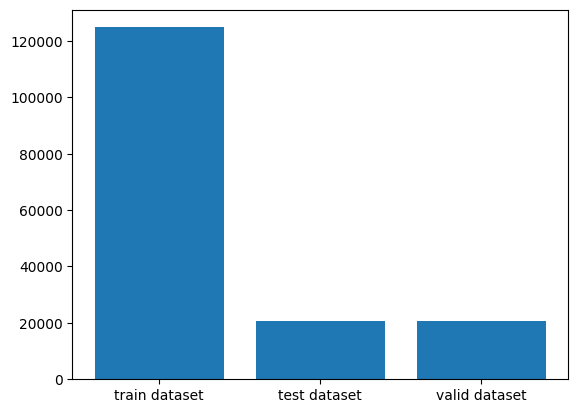

In [21]:
print(f"Rozmiar danych uczących {train_dataset_len}")
print(f"Rozmiar danych validujących {test_dataset_len}")
print(f"Rozmiar danych testowych {test_dataset_len}")

plt.bar(["train dataset", "test dataset", "valid dataset"], [train_dataset_len, test_dataset_len, test_dataset_len] )

## Przetwarzanie zbioru pod Bayens i Logistic Regression

W przypadku tych algorytmów zastosowałem __CountVectorizer__. Wybiera najbardziej popularne słowa, ilość tych słów jest przekazywana w parametrze __max_features__. Następnie dla wprowadzonych ciągów zwraca tablice z informacją, które z tych najpopularniejszych słów wystąpiło.

In [22]:
s = CountVectorizer(binary=True, max_features=2).fit(["good good good bad bad fun", "good good bad", "good good bad bad bad"])
# 2 kolumna pokazuje wystepowanie good
print(s.transform(["good"]).toarray())
# 1 kolumna pokazuje wystepowanie bad
print(s.transform(["bad"]).toarray())
# fun nie jest najpopularniejszym słowem
print(s.transform(["fun"]).toarray())
print(s.transform(["good bad"]).toarray())
print(s.transform(["good good good bad fun"]).toarray())

[[0 1]]
[[1 0]]
[[0 0]]
[[1 1]]
[[1 1]]


In [23]:
#10 000
vec_large = CountVectorizer(binary=True, max_features=NUMBER_OF_CATEGORIZED_WORDS_LARGE)
vec_large.fit(df.tweets)

#1 500
vec_small = CountVectorizer(binary=True, max_features=NUMBER_OF_CATEGORIZED_WORDS_SMALL)
vec_small.fit(df.tweets)

X_large_vectorized_train = vec_large.transform(X_train)
X_large_vectorized_valid = vec_large.transform(X_valid)
X_large_vectorized_test = vec_large.transform(X_test)

X_small_vectorized_train = vec_small.transform(X_train)
X_small_vectorized_valid = vec_small.transform(X_valid)
X_small_vectorized_test = vec_small.transform(X_test)

## Przetwarzanie zbioru pod RNN

In [24]:
words = tf.constant(vec_large.get_feature_names_out())
word_ids = tf.range(len(vec_large.get_feature_names_out()), dtype=tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
num_oov_buckets = 1000 # dodatkowe 1000 slow spoza slownika
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

2023-05-01 16:03:40.772065: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-01 16:03:40.772271: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-01 16:03:40.772388: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Do przetwarzania pod RNN wykorzystałem listę 10 000 najpopularniejszych słów z poprzedniego kroku. Następnie każdy tweet zostanie podzielone na słowa, a do każdego słowa zostanie dopasowany token. 

tutaj zdanie "ai real danger" zostało zamienione na tablice tokenów [171, 7234, 2102]

In [25]:
table.lookup(tf.strings.split("ai real danger")).numpy()

array([ 171, 7234, 2102])

In [26]:
X_train_tokenized = table.lookup(tf.strings.split(X_train)).to_tensor()

In [27]:
y_train_tokenized = tf.convert_to_tensor(np.where(y_train=="good", 2, np.where(y_train=="neutral", 1, 0)), dtype=tf.int64)

In [28]:
X_valid_tokenized = table.lookup(tf.strings.split(X_valid)).to_tensor()

In [29]:
y_valid_tokenized = tf.convert_to_tensor(np.where(y_valid=="good", 2, np.where(y_valid=="neutral", 1, 0)),dtype=tf.int64)

In [30]:
X_test_tokenized = table.lookup(tf.strings.split(X_test)).to_tensor()

In [31]:
y_test_tokenized = tf.convert_to_tensor(np.where(y_test=="good", 2, np.where(y_test=="neutral", 1, 0)), dtype=tf.int64)

# Bayens 

In [32]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_small_vectorized_train.toarray(), y_train);

In [33]:
bayens_predict = gnb.predict(X_small_vectorized_test.toarray())
bayens_acc=accuracy_score(bayens_predict, y_test)

In [34]:
conf_mat_bayens = confusion_matrix(bayens_predict, y_test)
bayens_plot_conf = ConfusionMatrixDisplay(confusion_matrix=conf_mat_bayens, display_labels=["good", "neutral", "bad"])

In [35]:
bayens_acc

0.5837378057571243

# Logistic regression

In [36]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver="liblinear", random_state=RANDOM_SEED, C=5, penalty="l2", max_iter=1000)
lr.fit(X_large_vectorized_train,y_train);

In [37]:
lr_predict = lr.predict(X_large_vectorized_test)
lr_acc = accuracy_score(lr_predict, y_test)

In [38]:
conf_mat_lr = confusion_matrix(lr_predict, y_test)
lr_plot_conf = ConfusionMatrixDisplay(confusion_matrix=conf_mat_lr, display_labels=["good", "neutral", "bad"])

In [39]:
lr_acc

0.8118121966456822

# RNN

In [40]:


embed_size = 128
rnn_model = keras.models.Sequential([
    keras.layers.Embedding(NUMBER_OF_CATEGORIZED_WORDS_LARGE + num_oov_buckets, embed_size,
                           mask_zero=True, 
                           input_shape=[None]),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.GRU(128),
    keras.layers.Dense(3, activation="sigmoid")
])
rnn_model.compile(loss="SparseCategoricalCrossentropy", optimizer="adam", metrics=["accuracy"])
rnn_history = rnn_model.fit(x=X_train_tokenized, y=y_train_tokenized, epochs=5, validation_data=(X_valid_tokenized, y_valid_tokenized))



Epoch 1/5


2023-05-01 16:04:20.848570: W tensorflow/core/common_runtime/type_inference.cc:339] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT8
    }
  }
}

	while inferring type of node 'cond_41/output/_22'
2023-05-01 16:04:22.315921: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2023-05-01 16:04:23.636552: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x55c0eb37ad80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-01 16:04:23.636585: I tensorflow/compiler/x

3902/3902 [==============================] - 193s 48ms/step - loss: 0.4709 - accuracy: 0.8153 - val_loss: 0.3808 - val_accuracy: 0.8580
Epoch 2/5
3902/3902 [==============================] - 183s 47ms/step - loss: 0.3303 - accuracy: 0.8778 - val_loss: 0.3624 - val_accuracy: 0.8677
Epoch 3/5
3902/3902 [==============================] - 149s 38ms/step - loss: 0.2769 - accuracy: 0.8988 - val_loss: 0.3869 - val_accuracy: 0.8619
Epoch 4/5
3902/3902 [==============================] - 49s 13ms/step - loss: 0.2222 - accuracy: 0.9212 - val_loss: 0.4008 - val_accuracy: 0.8614
Epoch 5/5
3902/3902 [==============================] - 64s 16ms/step - loss: 0.1686 - accuracy: 0.9418 - val_loss: 0.4639 - val_accuracy: 0.8564


In [41]:
rnn_acc = rnn_model.evaluate(X_test_tokenized,y_test_tokenized)[1]

651/651 [==============================] - 6s 7ms/step - loss: 0.4483 - accuracy: 0.8616


In [42]:

rnn_predict = rnn_model.predict(X_test_tokenized).argmax(-1)
rnn_predict = np.vectorize(lambda x : ["bad","neutral", "good"][x])(rnn_predict)
conf_mat_rnn  = confusion_matrix(rnn_predict, y_test)
rnn_plot_conf = ConfusionMatrixDisplay(confusion_matrix=conf_mat_rnn, display_labels=["bad", "neutral", "good"])

651/651 [==============================] - 5s 6ms/step


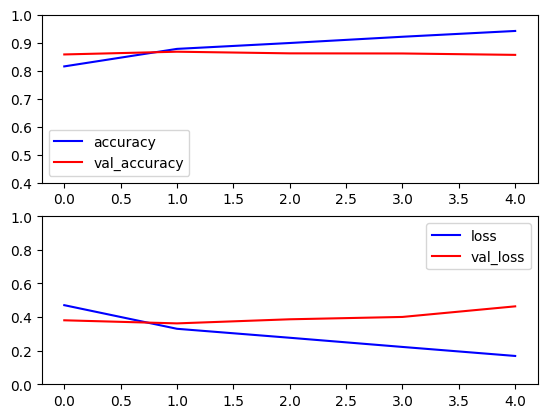

In [43]:
epochs = range(len(rnn_history.history['accuracy']))
plt.subplot(2,1, 1)
plt.plot(epochs, rnn_history.history['accuracy'], 'b', label='accuracy')
plt.plot(epochs, rnn_history.history['val_accuracy'], 'r', label='val_accuracy')
plt.ylim([0.4,1])
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(epochs, rnn_history.history['loss'], 'b', label='loss')
plt.plot(epochs, rnn_history.history['val_loss'], 'r', label='val_loss')
plt.ylim([0,1])
plt.legend()

In [44]:
rnn_acc

0.8615502715110779

# BERT

In [45]:
def build_bert_model(preprocessor_url, model_url):
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(preprocessor_url, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(model_url, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(3, activation="softmax", name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [46]:
bert_model_url = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1"
bert_preprocessor_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

In [47]:
bert_model = build_bert_model(bert_preprocessor_url, bert_model_url)

2023-05-01 16:15:07.781750: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-05-01 16:15:07.782201: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-05-01 16:15:07.782304: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-05-01 16:15:07.782629: I tensorflow/core/

In [48]:
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
bert_model.compile(optimizer="adam", loss="SparseCategoricalCrossentropy", metrics=['accuracy'])

bert_history = bert_model.fit(x=X_train, y=y_train_tokenized, epochs=10, validation_data=(X_valid, y_valid_tokenized), callbacks=[es])

Epoch 1/10


2023-05-01 16:15:10.260408: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype int32 and shape [?,128]
	 [[{{node inputs}}]]
2023-05-01 16:15:10.260471: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs_1' with dtype int32 and shape [?,128]
	 [[{{node inputs_1}}]]
2023-05-01 16:15:10.816963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/bert_encoder/StatefulPartitionedCall_grad/bert_encoder/StatefulPart

3902/3902 [==============================] - 1034s 263ms/step - loss: 0.8043 - accuracy: 0.6476 - val_loss: 0.7274 - val_accuracy: 0.7105
Epoch 2/10
3902/3902 [==============================] - 496s 127ms/step - loss: 0.7452 - accuracy: 0.6861 - val_loss: 0.7177 - val_accuracy: 0.7012
Epoch 3/10
3902/3902 [==============================] - 496s 127ms/step - loss: 0.7093 - accuracy: 0.7095 - val_loss: 0.6844 - val_accuracy: 0.7235
Epoch 4/10
3902/3902 [==============================] - 494s 127ms/step - loss: 0.7095 - accuracy: 0.7063 - val_loss: 0.7033 - val_accuracy: 0.7108
Epoch 5/10
3902/3902 [==============================] - 494s 127ms/step - loss: 0.6853 - accuracy: 0.7226 - val_loss: 0.8071 - val_accuracy: 0.6503
Epoch 6/10
3902/3902 [==============================] - 495s 127ms/step - loss: 0.6706 - accuracy: 0.7318 - val_loss: 0.6617 - val_accuracy: 0.7390
Epoch 7/10
3902/3902 [==============================] - 671s 172ms/step - loss: 0.6757 - accuracy: 0.7246 - val_loss: 0.67

In [49]:
bert_acc = bert_model.evaluate(X_test,y_test_tokenized)[1]

651/651 [==============================] - 75s 115ms/step - loss: 0.6687 - accuracy: 0.7385


In [55]:
bert_predict = bert_model.predict(X_test).argmax(-1)
bert_predict = np.vectorize(lambda x : ["bad","neutral", "good"][x])(bert_predict)
conf_mat_bert  = confusion_matrix(bert_predict, y_test)
bert_plot_conf = ConfusionMatrixDisplay(confusion_matrix=conf_mat_bert, display_labels=["bad", "neutral", "good"])


651/651 [==============================] - 44s 67ms/step


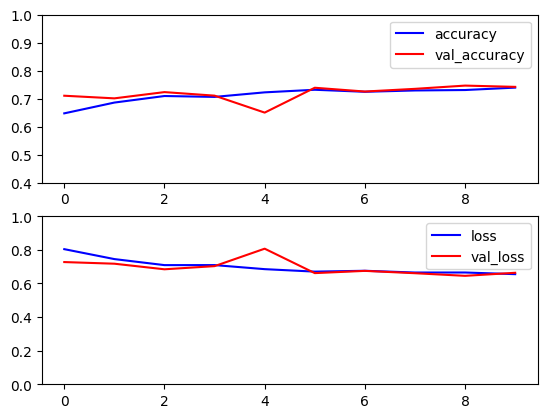

In [51]:
epochs = range(len(bert_history.history['accuracy']))
plt.subplot(2,1, 1)
plt.plot(epochs, bert_history.history['accuracy'], 'b', label='accuracy')
plt.plot(epochs, bert_history.history['val_accuracy'], 'r', label='val_accuracy')
plt.ylim([0.4,1])
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(epochs, bert_history.history['loss'], 'b', label='loss')
plt.plot(epochs, bert_history.history['val_loss'], 'r', label='val_loss')
plt.ylim([0,1])
plt.legend()

In [52]:
bert_acc

0.7384785413742065

# Podsumowanie

Text(0.5, 1.0, 'BERT confusion matrix')

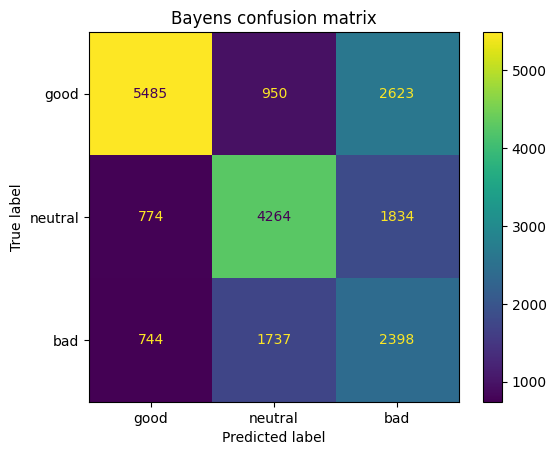

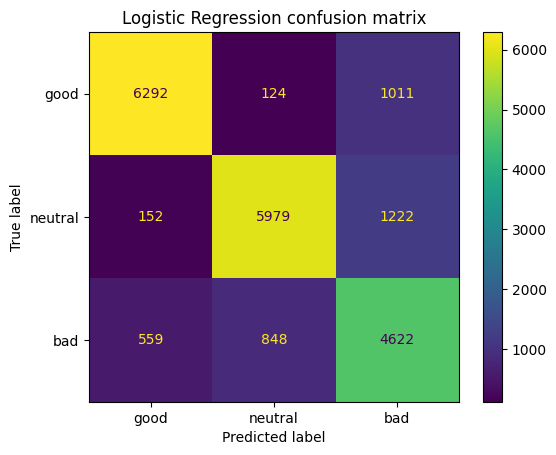

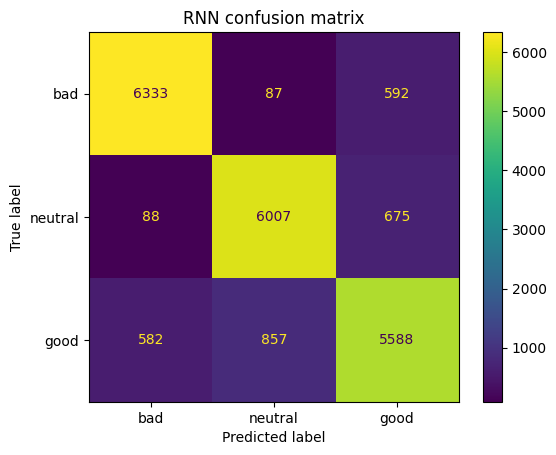

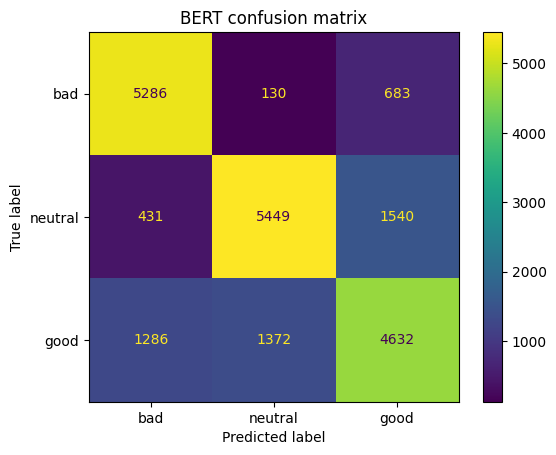

In [53]:
bayens_plot_conf.plot()
plt.title("Bayens confusion matrix")
lr_plot_conf.plot()
plt.title("Logistic Regression confusion matrix")
rnn_plot_conf.plot()
plt.title("RNN confusion matrix")
bert_plot_conf.plot()
plt.title("BERT confusion matrix")

In [54]:
summary = pd.DataFrame( data = {'accuracy': [bayens_acc, lr_acc, rnn_acc, bert_acc]}, index=["Bayens", "Logistic Regression", "RNN", "BERT"])
summary.sort_values(by=["accuracy"])

,accuracy
Bayens,0.583738
BERT,0.738479
Logistic Regression,0.811812
RNN,0.861550
